### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'diabetes'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_base'
MODE = 'fine_tune'
backbone_mode = 'eval'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


image_id  patient_id    camera  patient_age comorbidities diabetes_time_y  \
0  img00001           1  Canon CR         48.0     diabetes1              12   
1  img00002           1  Canon CR         48.0     diabetes1              12   
2  img00003           2  Canon CR         18.0     diabetes1               7   
3  img00004           2  Canon CR         18.0     diabetes1               7   
4  img00005           3  Canon CR         22.0     diabetes1              11   

  insuline  patient_sex  exam_eye diabetes  ... vascular_occlusion  \
0      yes            1         1      yes  ...                  0   
1      yes            1         2      yes  ...                  0   
2      yes            2         1      yes  ...                  0   
3      yes            2         2      yes  ...                  0   
4      yes            1         1      yes  ...                  0   

  hypertensive_retinopathy  drusens  hemorrhage  retinal_detachment  \
0                        0        0           0                   0   
1                        0        0           0                   0   
2                        0        0           0                   0   
3                        0        0           0                   0   
4                        0        0           0                   0   

   myopic_fundus  increased_cup_disc  other   quality  normality  
0              0                   1      0  Adequate   abnormal  
1              0                   1      0  Adequate   abnormal  
2              0                   0      0  Adequate     normal  
3              0                   0      0  Adequate     normal  
4              0                   0      0  Adequate     normal  

[5 rows x 35 columns]

In [4]:
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'True' if x == 'yes' else 'False')

Train data shape: (11386, 35)
Test data shape: (4880, 35)


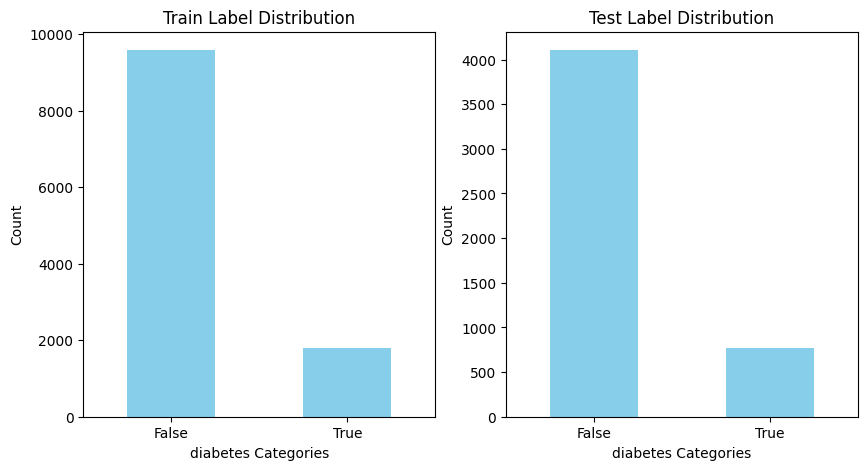

Getting validation set...
Train data shape: (10247, 35)
Test data shape: (1139, 35)


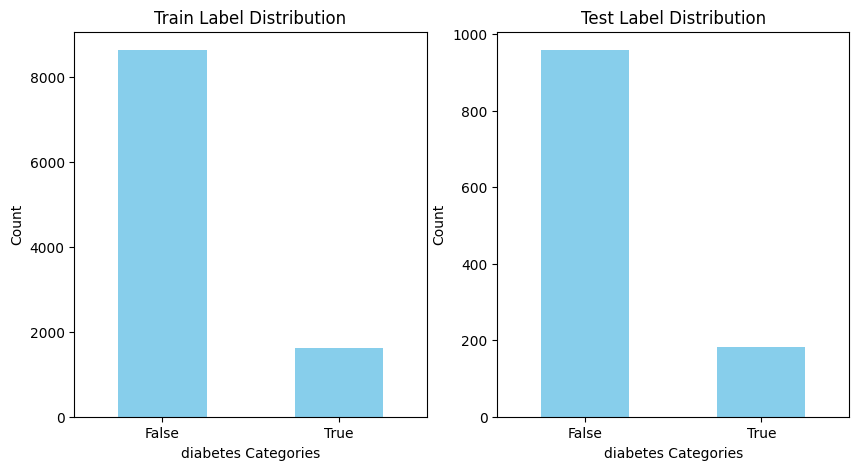

In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_train, df_val = split_data(df_train, LABEL, 0.10)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

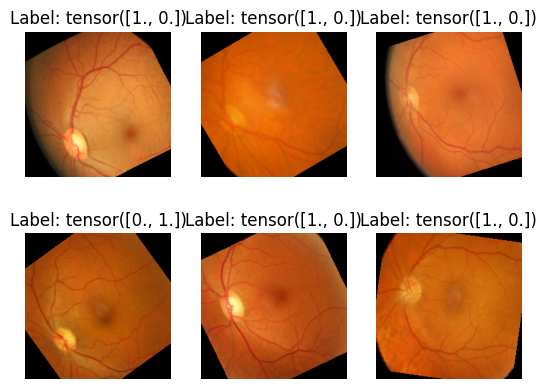

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])
    

Using 2 GPUs!


### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'convnextv2_binary_{LABEL}')

100%|██████████| 72/72 [00:20<00:00,  3.58it/s]


Epoch 1, Train Loss: 0.7062988780590004, Val Loss: 0.7445175167587068, F1 Score: 0.14397140276751486


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 2, Train Loss: 0.6967025791148128, Val Loss: 0.6709545958373282, F1 Score: 0.40768419222438923


100%|██████████| 72/72 [00:20<00:00,  3.44it/s]


Epoch 3, Train Loss: 0.6686280569680582, Val Loss: 0.6855417920483483, F1 Score: 0.49614221231019884


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 4, Train Loss: 0.6540184619367215, Val Loss: 0.7266467184656196, F1 Score: 0.31079682143994103


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 5, Train Loss: 0.6602410098040904, Val Loss: 0.6852681007650163, F1 Score: 0.5103266609510319


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 6, Train Loss: 0.6488672229410519, Val Loss: 0.6754732632802593, F1 Score: 0.5812149268690172


100%|██████████| 72/72 [00:20<00:00,  3.51it/s]


Epoch 7, Train Loss: 0.6672766167269482, Val Loss: 0.5651493167711629, F1 Score: 0.531299532615322


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 8, Train Loss: 0.59893542588594, Val Loss: 0.5520736301938692, F1 Score: 0.5285283793628717


100%|██████████| 72/72 [00:20<00:00,  3.45it/s]


Epoch 9, Train Loss: 0.574745327885177, Val Loss: 0.5348608021934828, F1 Score: 0.6262195436649947


100%|██████████| 72/72 [00:20<00:00,  3.48it/s]


Epoch 10, Train Loss: 0.571511589327766, Val Loss: 0.6206874007152187, F1 Score: 0.6364423312632783


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 11, Train Loss: 0.6011701587953732, Val Loss: 0.5717502252923118, F1 Score: 0.6640184809556006


100%|██████████| 72/72 [00:20<00:00,  3.47it/s]


Epoch 12, Train Loss: 0.5700397152982525, Val Loss: 0.7157877141402827, F1 Score: 0.43445701683489024


100%|██████████| 72/72 [00:20<00:00,  3.53it/s]


Epoch 13, Train Loss: 0.5625077513469363, Val Loss: 0.49232907800210846, F1 Score: 0.6689772365933188


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 14, Train Loss: 0.5309465116532098, Val Loss: 0.5028006947702832, F1 Score: 0.5946816072619062


100%|██████████| 72/72 [00:20<00:00,  3.55it/s]


Epoch 15, Train Loss: 0.5241644276239199, Val Loss: 0.459722646822532, F1 Score: 0.6584200670600401


100%|██████████| 72/72 [00:20<00:00,  3.51it/s]


Epoch 16, Train Loss: 0.5233455639268604, Val Loss: 0.5191133270661036, F1 Score: 0.7082089552238806


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 17, Train Loss: 0.5190238520479797, Val Loss: 0.4436728907749057, F1 Score: 0.6958369554718439


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 18, Train Loss: 0.550220045814648, Val Loss: 0.5987721416685317, F1 Score: 0.6620298870298871


100%|██████████| 72/72 [00:20<00:00,  3.51it/s]


Epoch 19, Train Loss: 0.56609695822047, Val Loss: 0.4782556210541063, F1 Score: 0.612290421872171


100%|██████████| 72/72 [00:20<00:00,  3.48it/s]


Epoch 20, Train Loss: 0.5139772550038726, Val Loss: 0.45045956948565113, F1 Score: 0.67708215428763


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 21, Train Loss: 0.5065822472066478, Val Loss: 0.4478518935955233, F1 Score: 0.6990962180200223


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 22, Train Loss: 0.4959724772134549, Val Loss: 0.482145538346635, F1 Score: 0.710463319198841


100%|██████████| 72/72 [00:20<00:00,  3.53it/s]


Epoch 23, Train Loss: 0.4955942822088503, Val Loss: 0.4355439104967647, F1 Score: 0.6669184842207871


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 24, Train Loss: 0.49140134581630573, Val Loss: 0.4370250296261575, F1 Score: 0.7140353059325392


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 25, Train Loss: 0.48818532355397054, Val Loss: 0.46309448902805644, F1 Score: 0.687452186928322


100%|██████████| 72/72 [00:20<00:00,  3.47it/s]


Epoch 26, Train Loss: 0.4665401740444246, Val Loss: 0.4332401652096046, F1 Score: 0.7044349184817412


100%|██████████| 72/72 [00:20<00:00,  3.48it/s]


Epoch 27, Train Loss: 0.4760497101523017, Val Loss: 0.5403423857771688, F1 Score: 0.5778412288769613


100%|██████████| 72/72 [00:20<00:00,  3.44it/s]


Epoch 28, Train Loss: 0.4749303323197848, Val Loss: 0.5143643037623001, F1 Score: 0.7155344655344655


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 29, Train Loss: 0.459406901923896, Val Loss: 0.4767495168166028, F1 Score: 0.7164038935539123


100%|██████████| 72/72 [00:20<00:00,  3.47it/s]


Epoch 30, Train Loss: 0.45555646629210755, Val Loss: 0.4526827959343791, F1 Score: 0.732152038656688


100%|██████████| 72/72 [00:20<00:00,  3.53it/s]


Epoch 31, Train Loss: 0.4516782891034336, Val Loss: 0.4212158140208986, F1 Score: 0.674265637128733


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 32, Train Loss: 0.4650711567837065, Val Loss: 0.47481313968698186, F1 Score: 0.7545407636738906


100%|██████████| 72/72 [00:20<00:00,  3.47it/s]


Epoch 33, Train Loss: 0.4361257643065475, Val Loss: 0.42067063899917734, F1 Score: 0.7102148257879057


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 34, Train Loss: 0.41235467049986263, Val Loss: 0.4248454651484887, F1 Score: 0.7024761452441605


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 35, Train Loss: 0.4098987903870212, Val Loss: 0.41309525734848446, F1 Score: 0.7193208361822718


100%|██████████| 72/72 [00:20<00:00,  3.47it/s]


Epoch 36, Train Loss: 0.3956079137701884, Val Loss: 0.43278989899489617, F1 Score: 0.7247887546395009


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 37, Train Loss: 0.4036685550198912, Val Loss: 0.4316646135929558, F1 Score: 0.7252820862782214


100%|██████████| 72/72 [00:20<00:00,  3.59it/s]


Epoch 38, Train Loss: 0.4108970818834818, Val Loss: 0.4390118070360687, F1 Score: 0.7236342937310618


100%|██████████| 72/72 [00:20<00:00,  3.44it/s]


Epoch 39, Train Loss: 0.39317900868780714, Val Loss: 0.4571721826990445, F1 Score: 0.7213668907578416
Early stopping triggered.


### Test

100%|██████████| 305/305 [01:24<00:00,  3.62it/s]


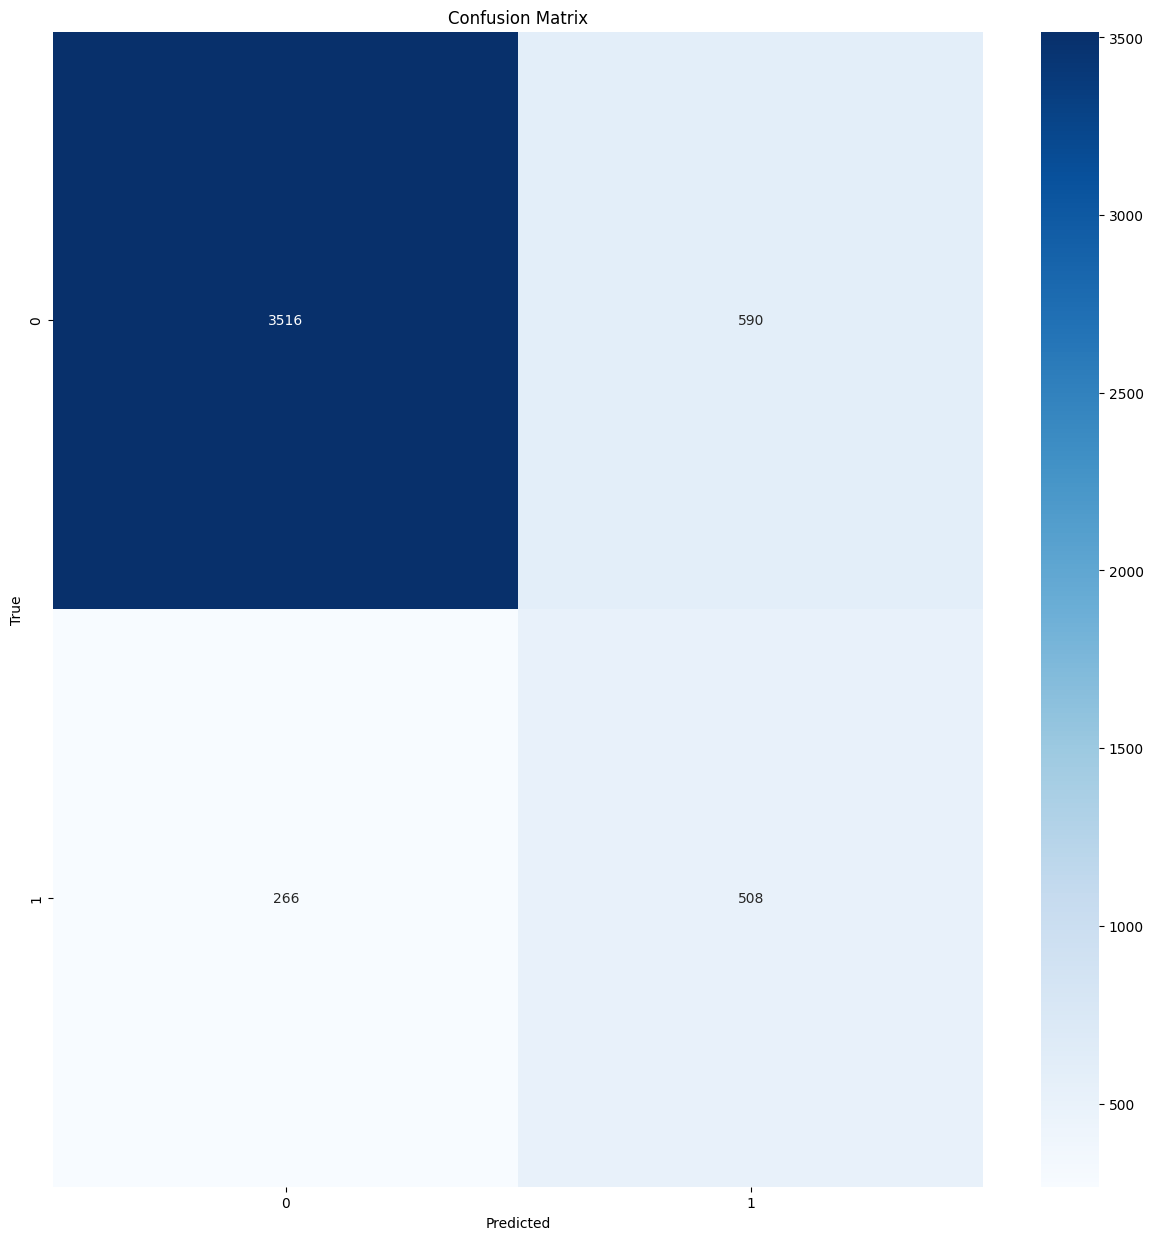

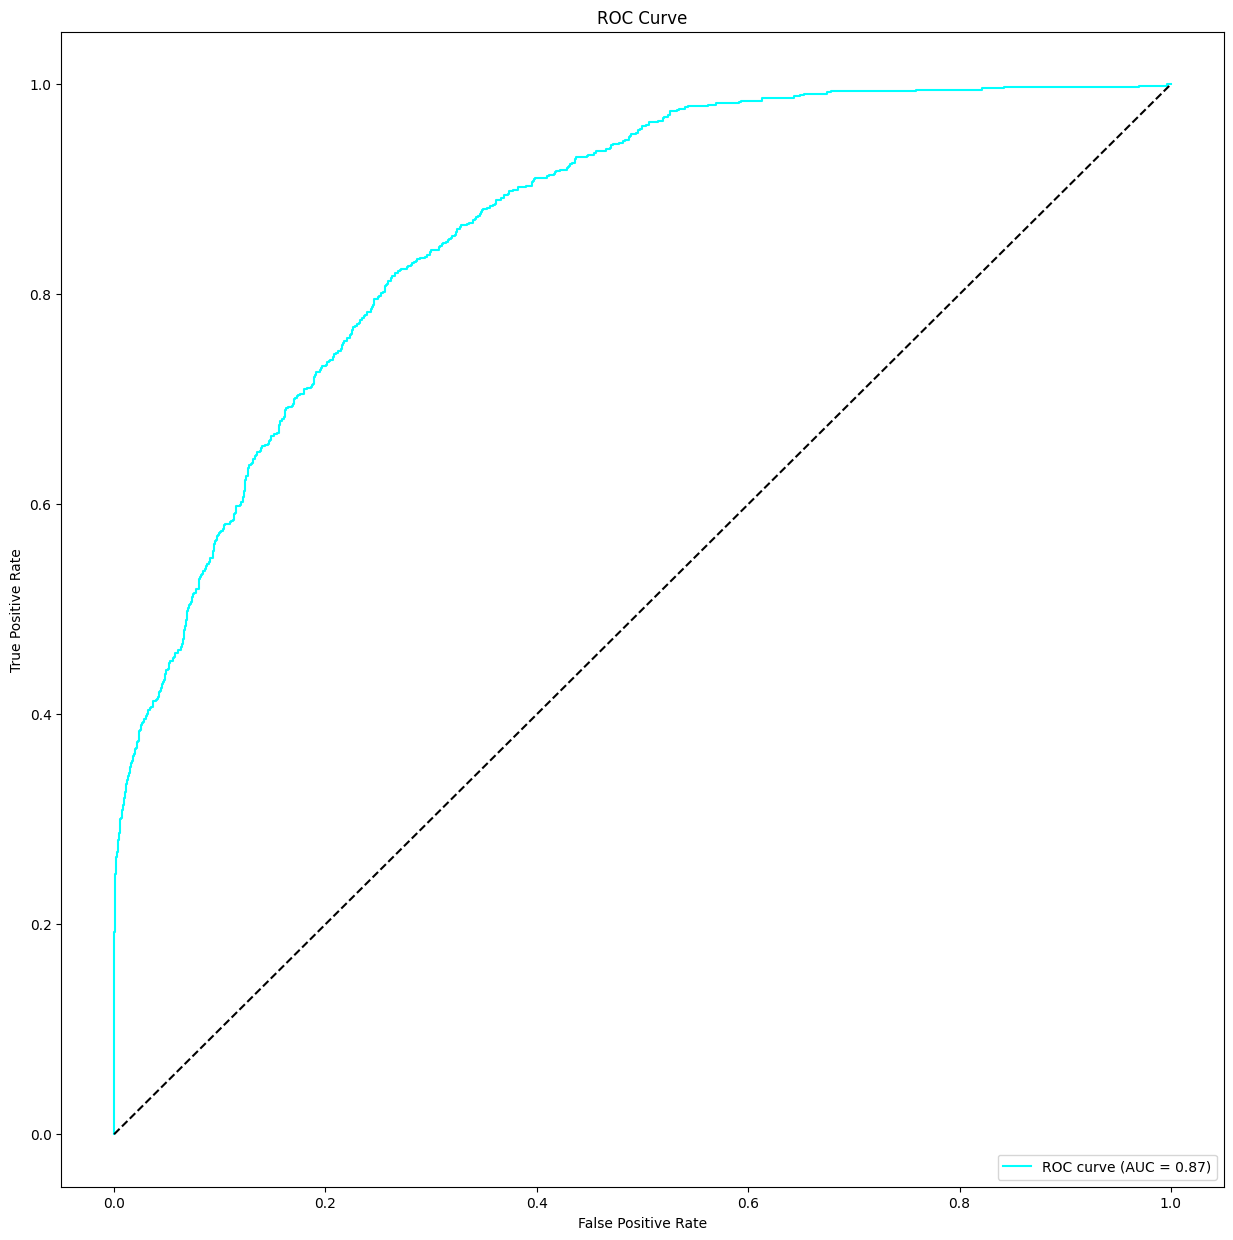

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      4106
           1       0.46      0.66      0.54       774

    accuracy                           0.82      4880
   macro avg       0.70      0.76      0.72      4880
weighted avg       0.86      0.82      0.84      4880

##################################################  Saliency Maps  ##################################################

Class 0:


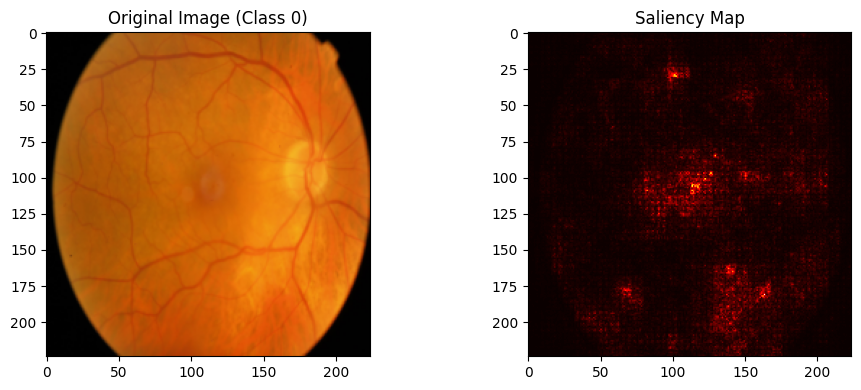

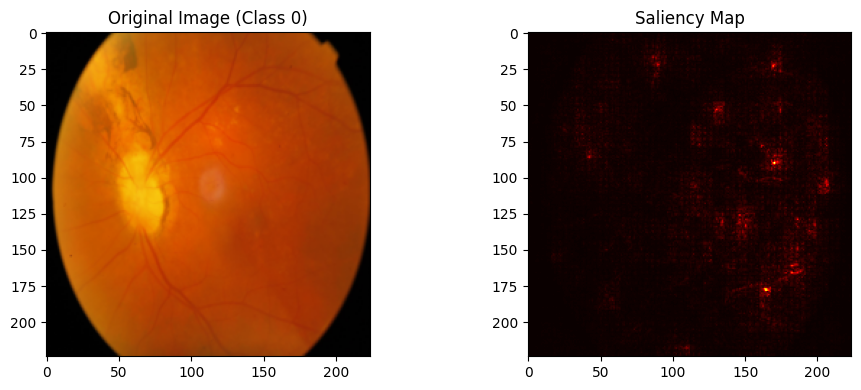

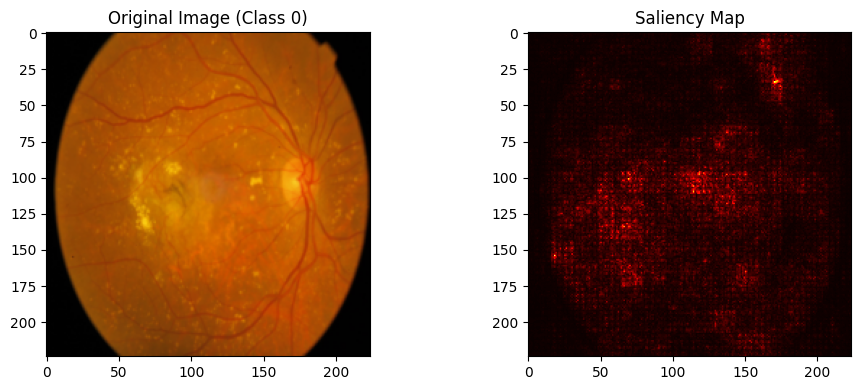

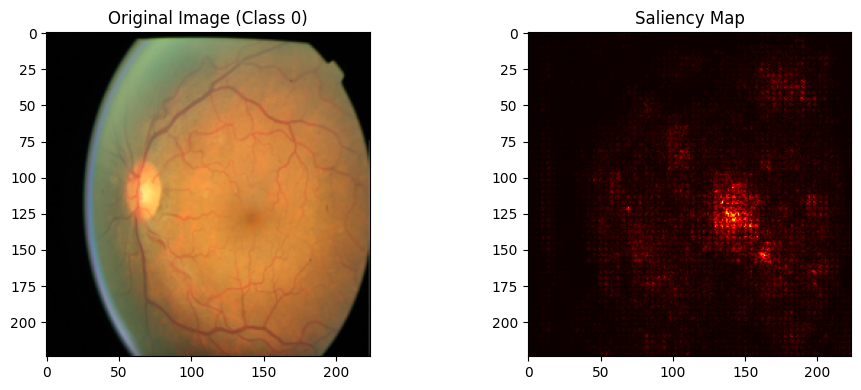

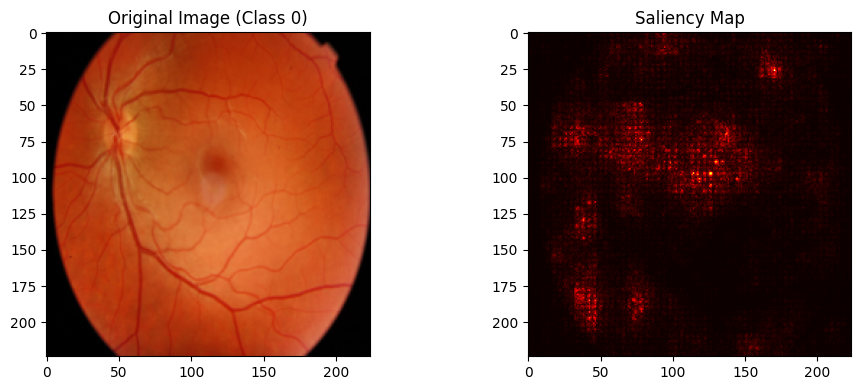

Class 1:


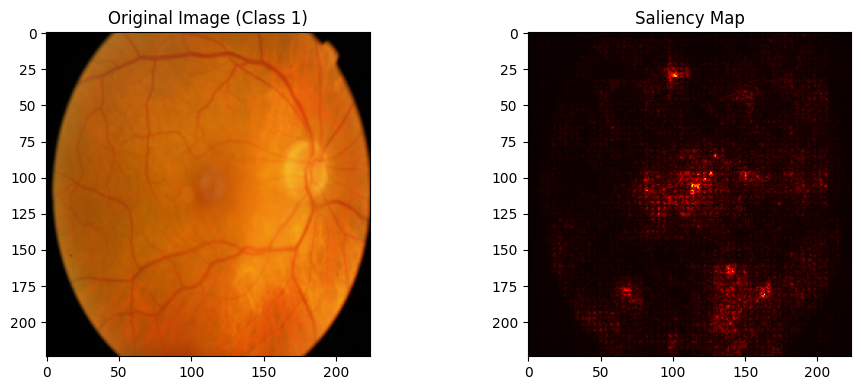

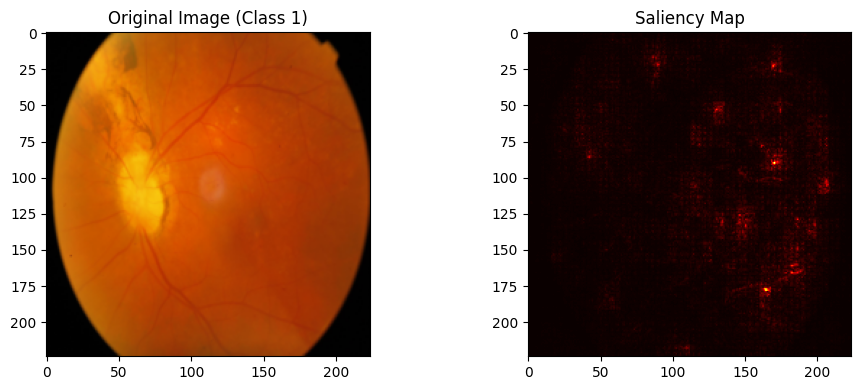

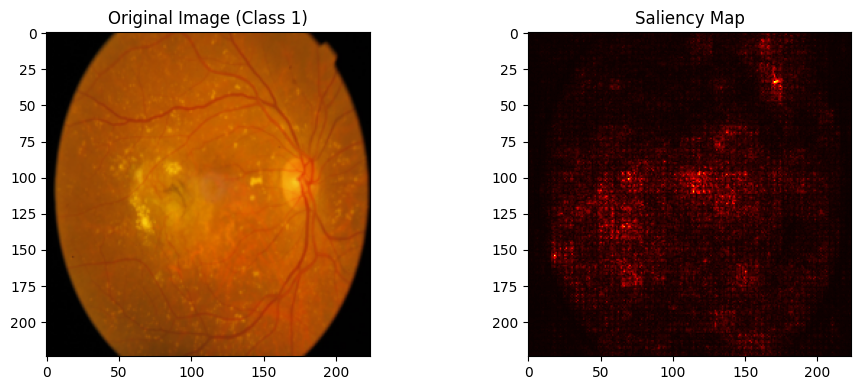

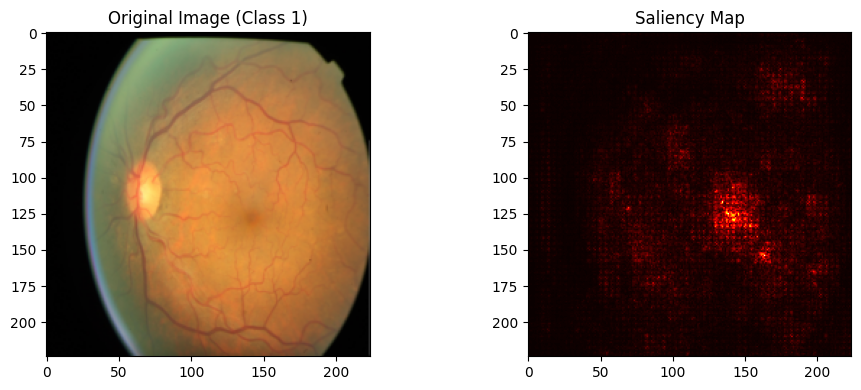

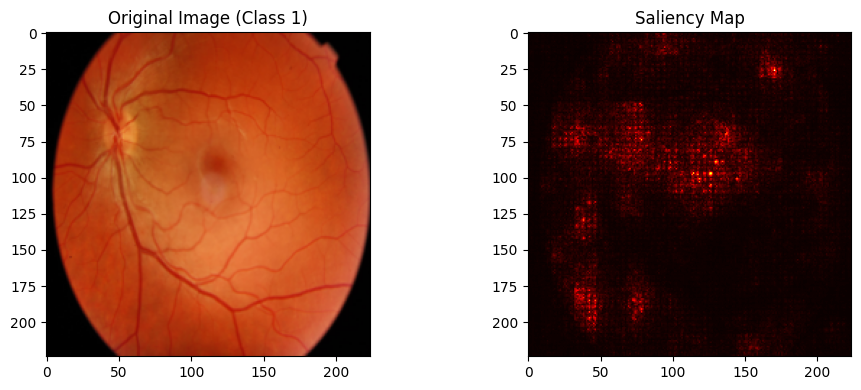

In [13]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [14]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


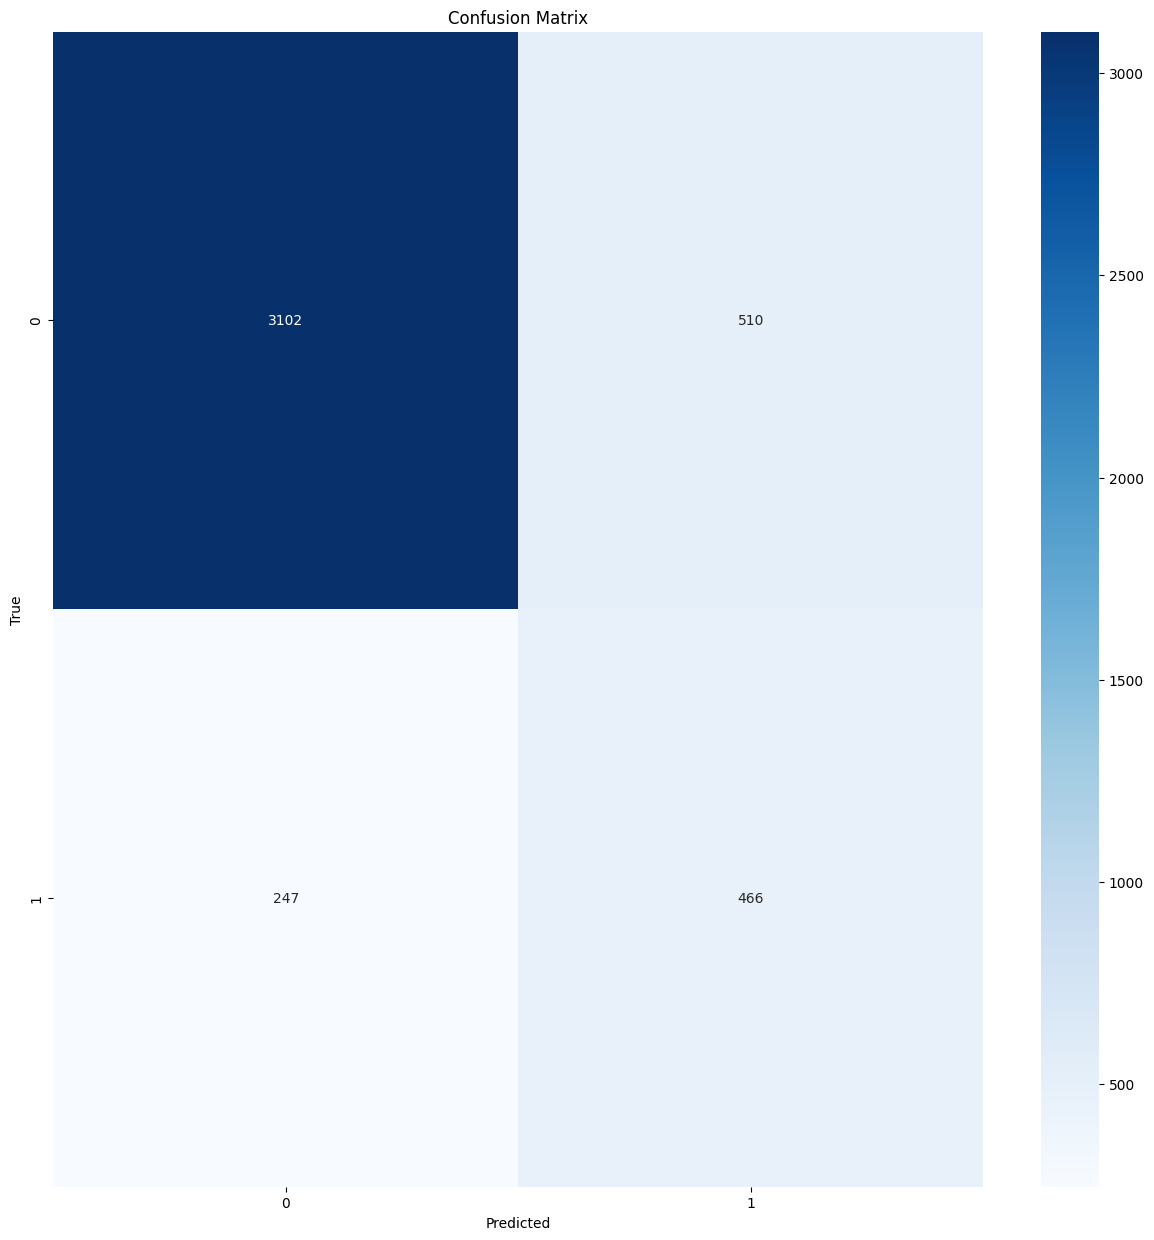

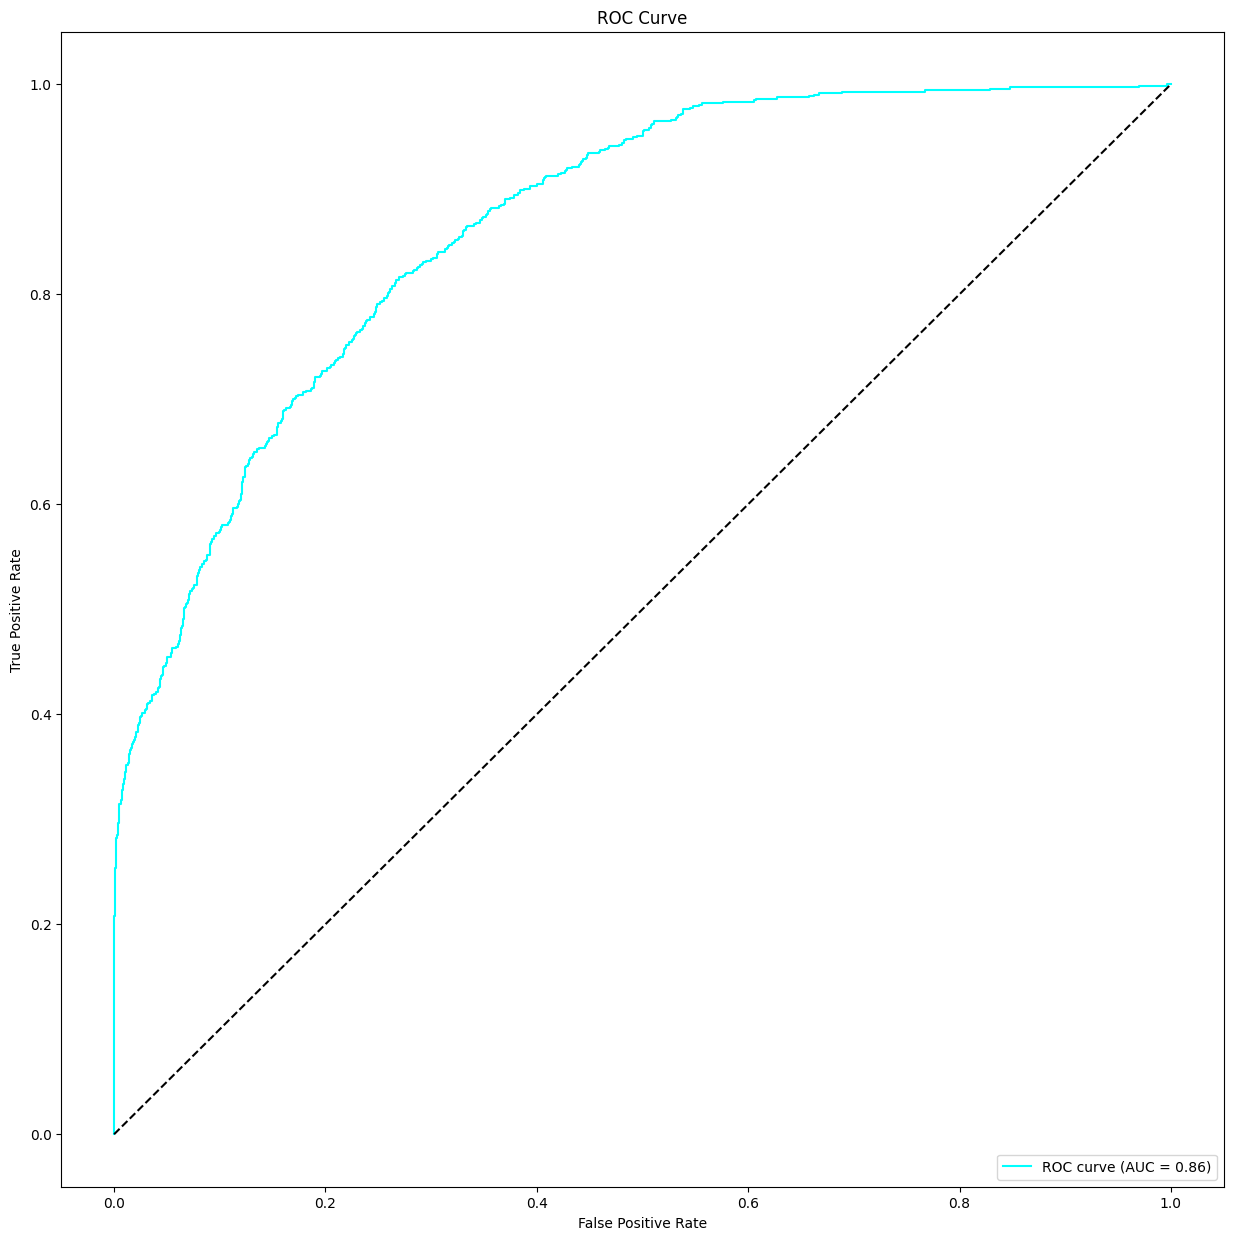

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      3612
           1       0.48      0.65      0.55       713

    accuracy                           0.82      4325
   macro avg       0.70      0.76      0.72      4325
weighted avg       0.85      0.82      0.84      4325

##################################################  Saliency Maps  ##################################################

Class 0:


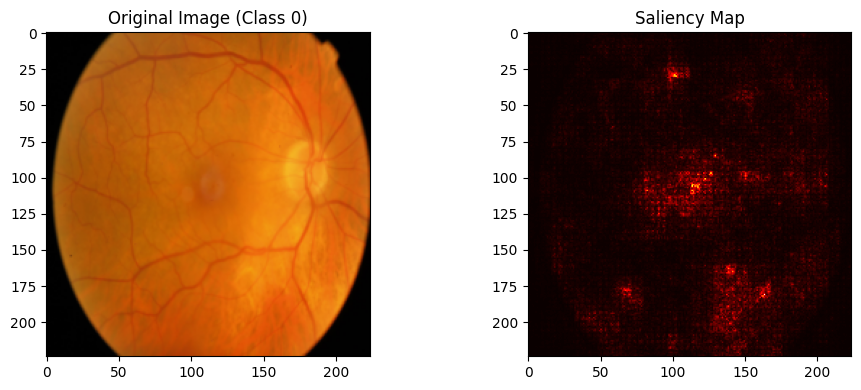

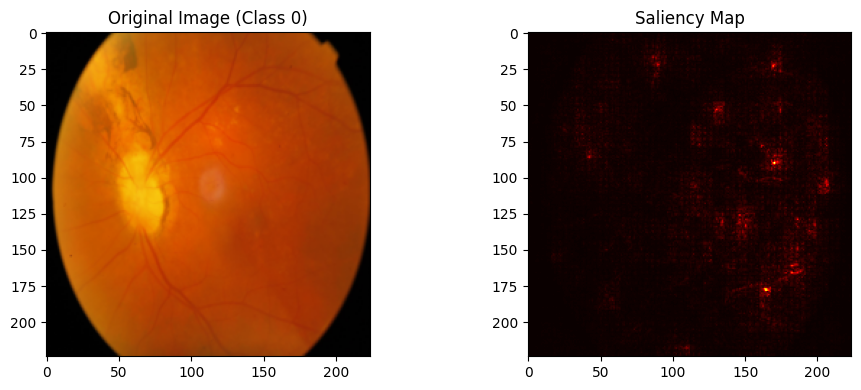

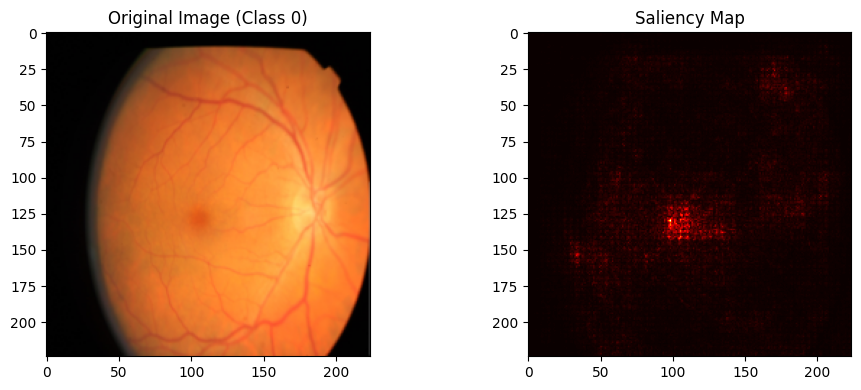

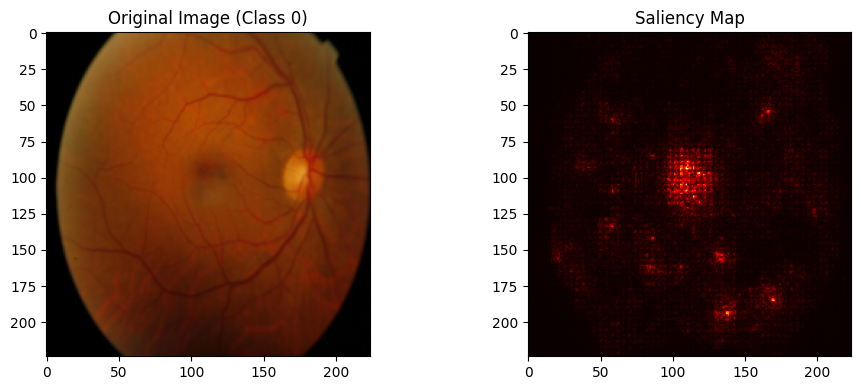

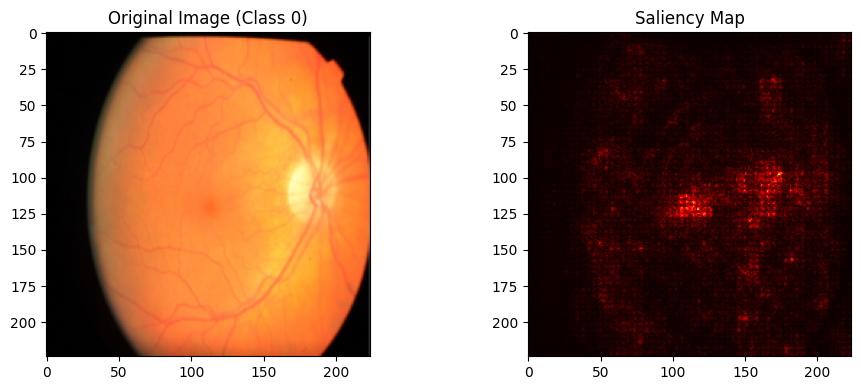

Class 1:


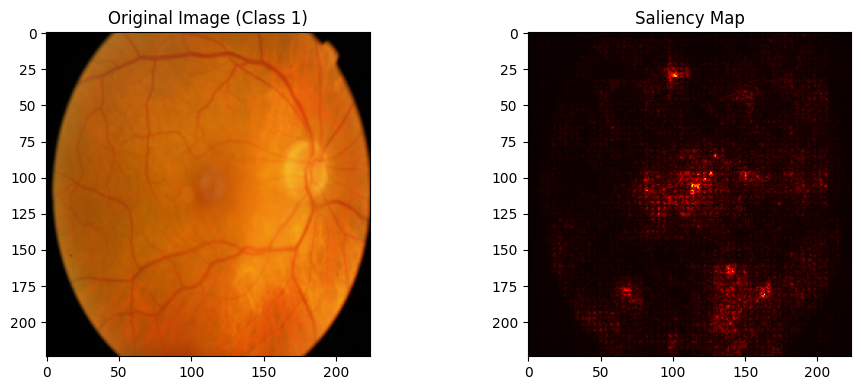

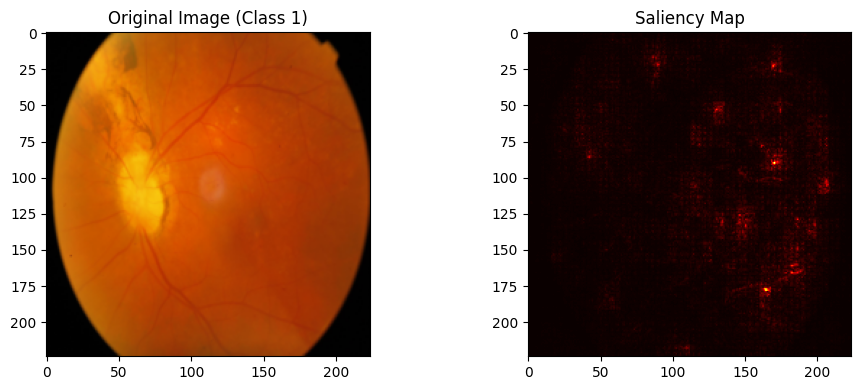

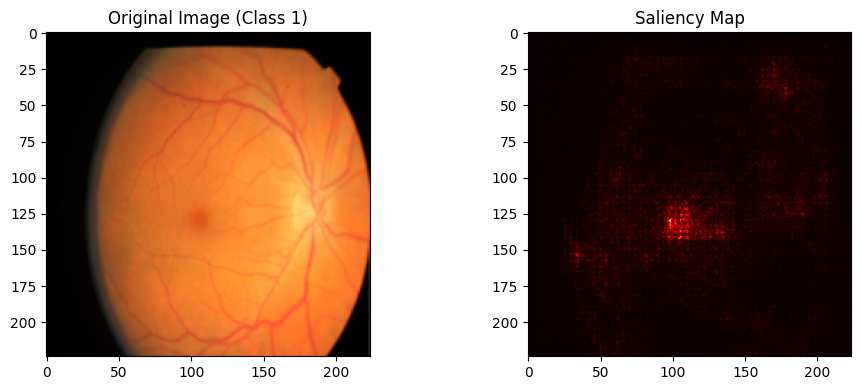

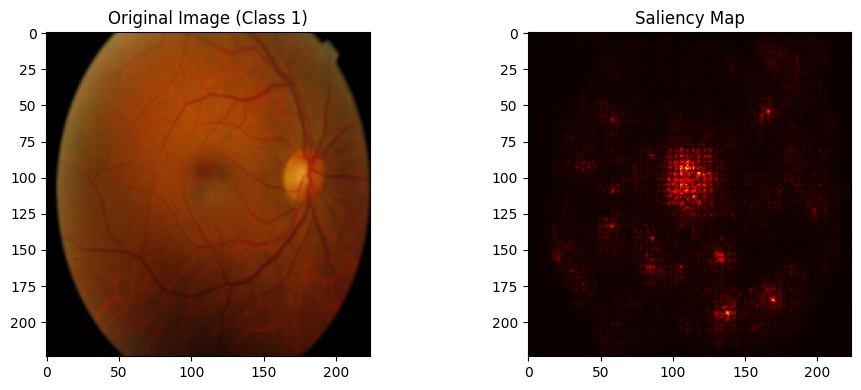

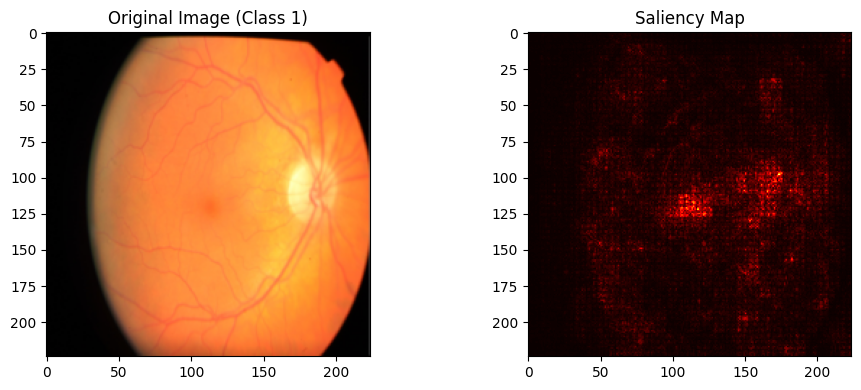

In [15]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 35/35 [00:10<00:00,  3.33it/s]


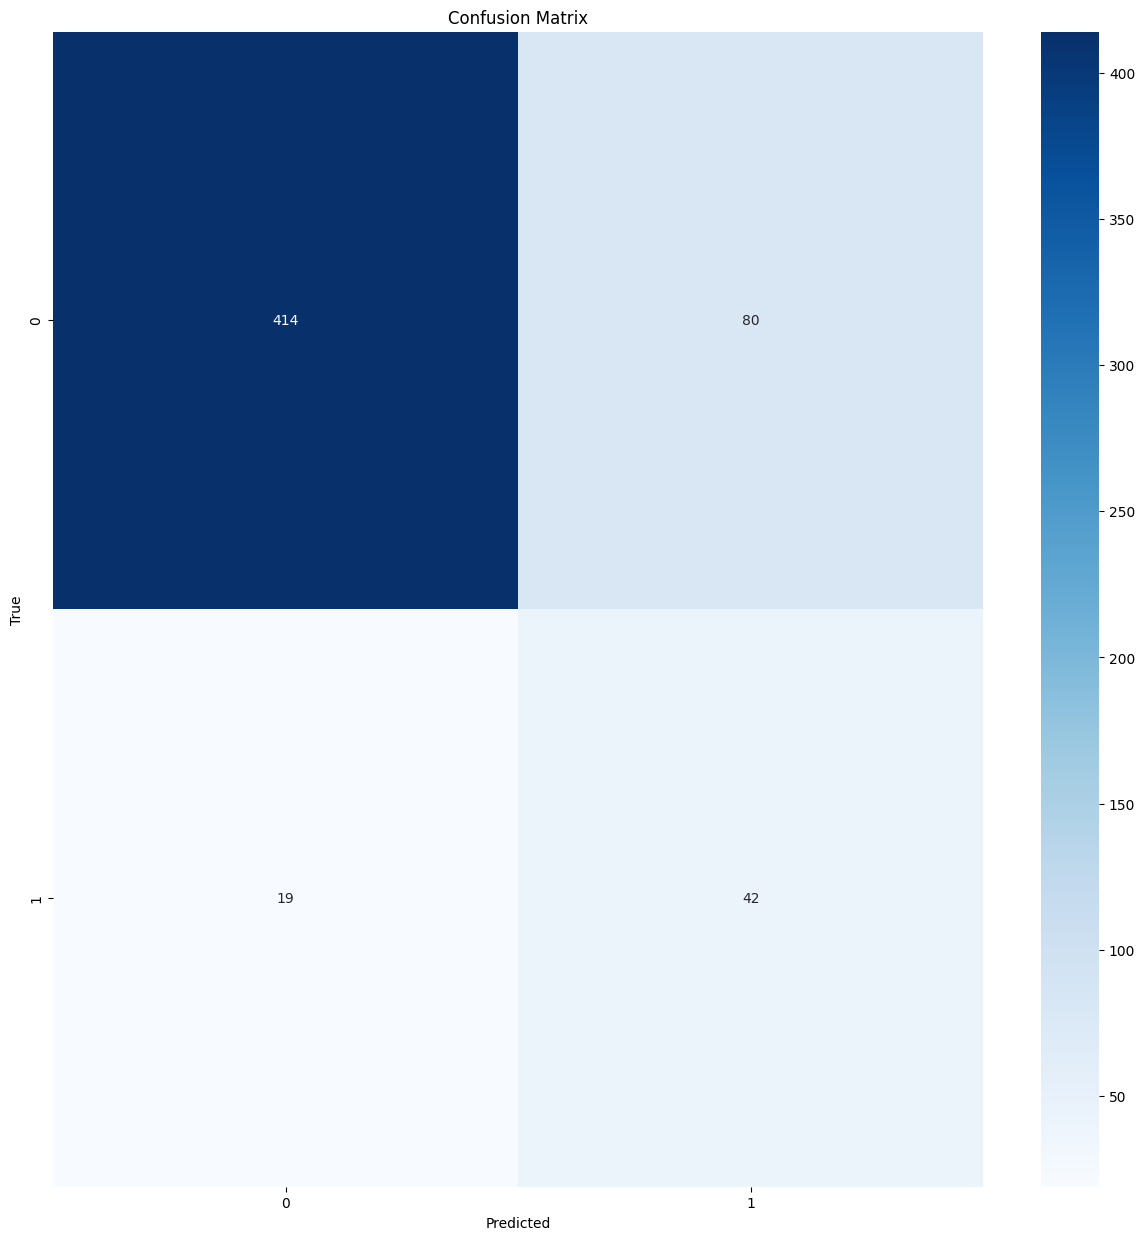

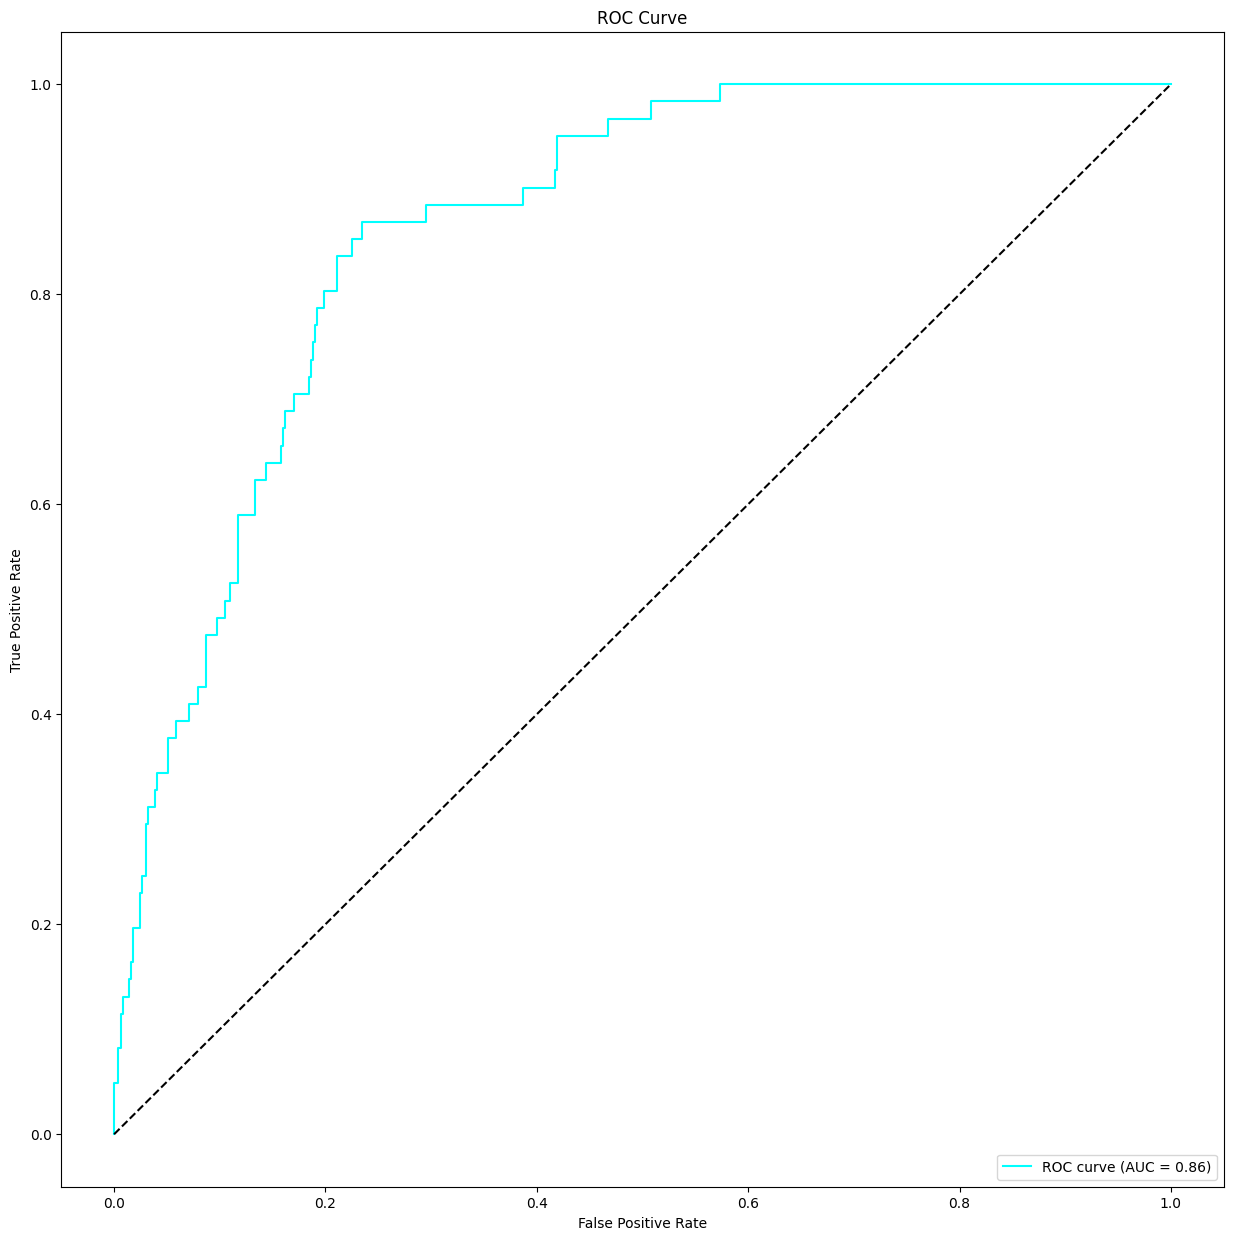

              precision    recall  f1-score   support

           0       0.96      0.84      0.89       494
           1       0.34      0.69      0.46        61

    accuracy                           0.82       555
   macro avg       0.65      0.76      0.68       555
weighted avg       0.89      0.82      0.85       555

##################################################  Saliency Maps  ##################################################

Class 0:


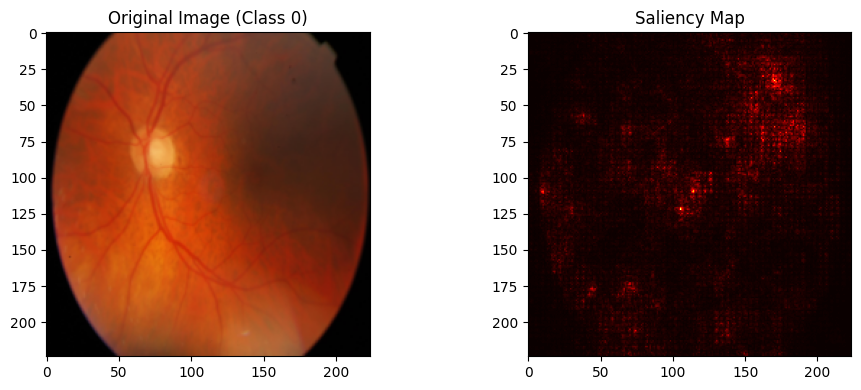

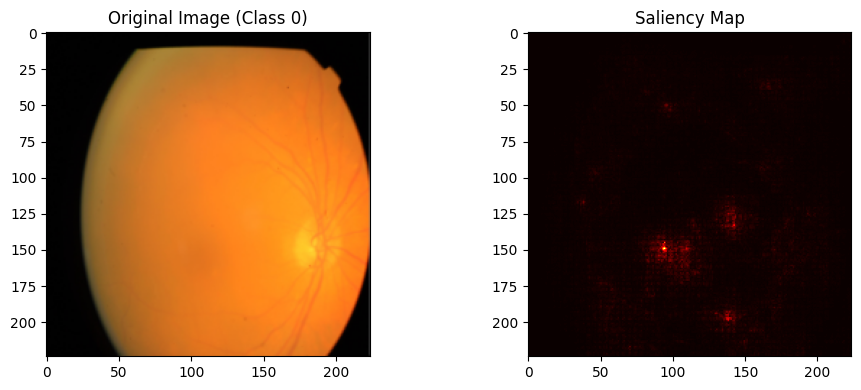

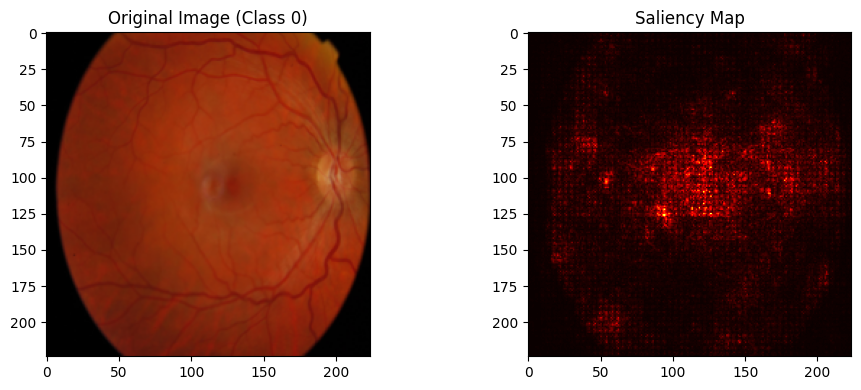

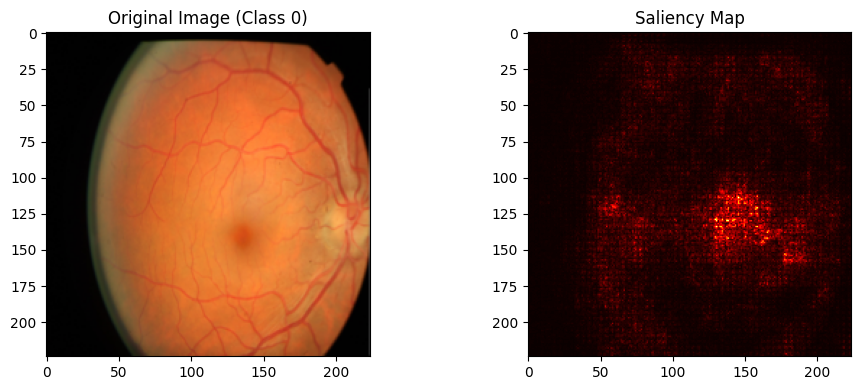

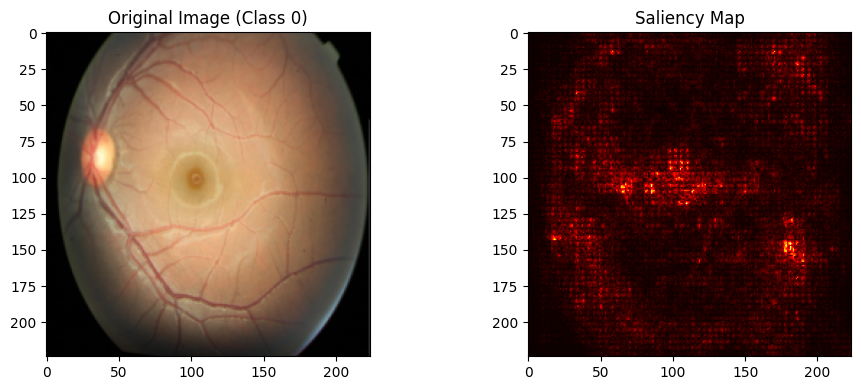

Class 1:


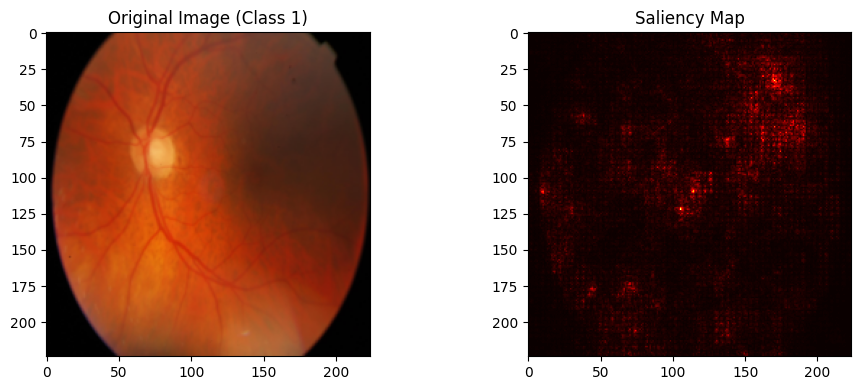

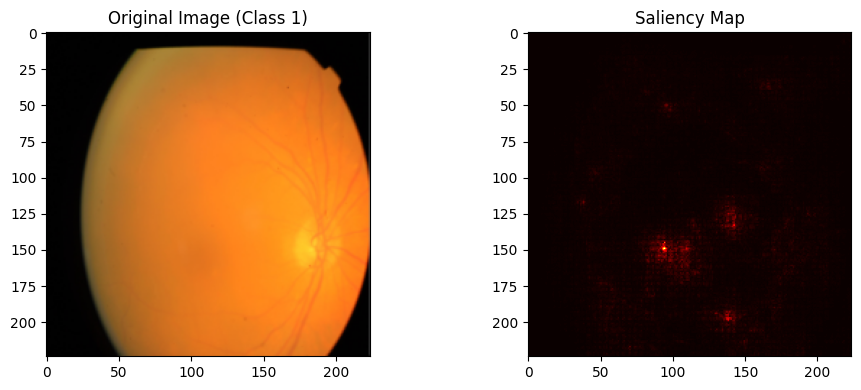

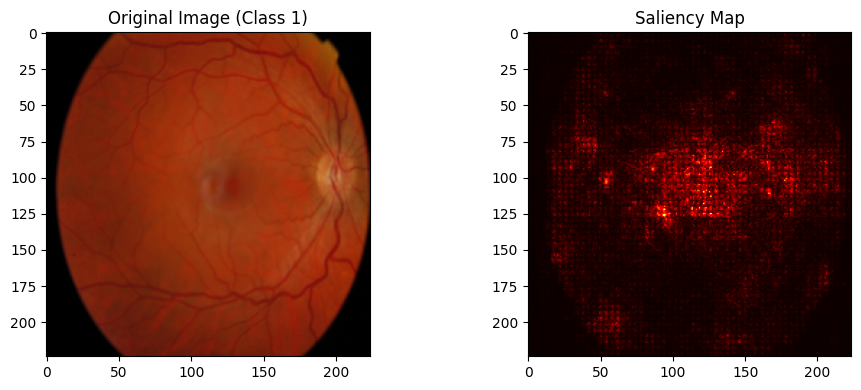

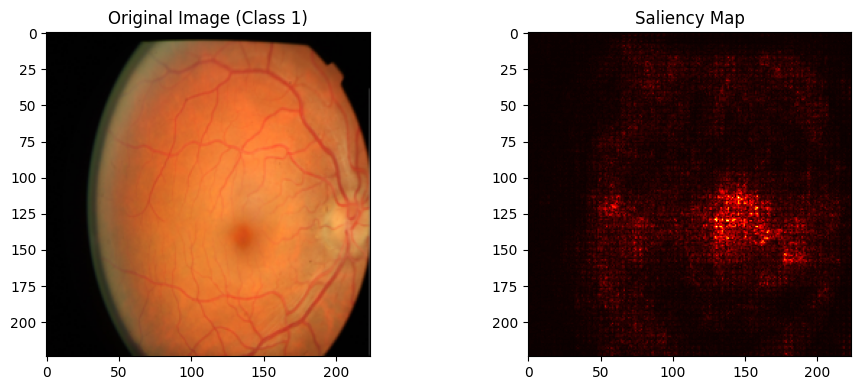

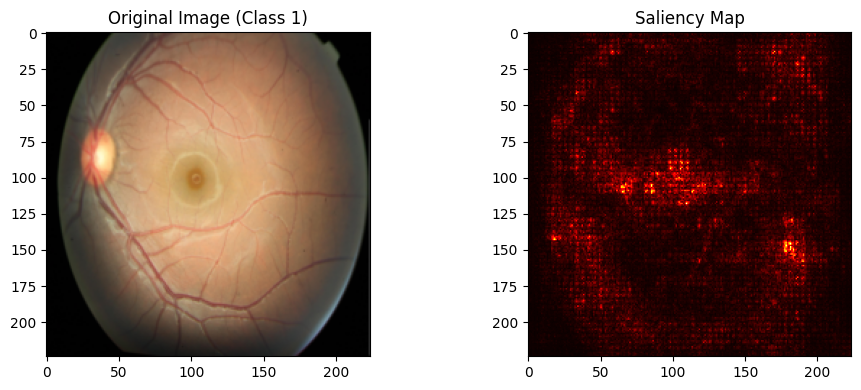

In [16]:
test(model, inadequate_dataloader, saliency=True, device=device)